In [1]:
import os
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt
import re
import numpy as np

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hard-coded sample image paths
sampler_path = "Sampler"
sample_paths = {}
sample_paths["driving"] = (os.path.join(sampler_path, "Driving/RGB_cleanpass/left/0400.png"), 
                           os.path.join(sampler_path, "Driving/RGB_cleanpass/left/0401.png"), 
                     os.path.join(sampler_path, "Driving/optical_flow/forward/0400.pfm"))
sample_paths["flying"] = (os.path.join(sampler_path, "FlyingThings3D/RGB_cleanpass/left/0006.png"), 
                           os.path.join(sampler_path, "FlyingThings3D/RGB_cleanpass/left/0007.png"), 
                     os.path.join(sampler_path, "FlyingThings3D/optical_flow/forward/0006.pfm"))
sample_paths["monkey"] = (os.path.join(sampler_path, "Monkaa/RGB_cleanpass/left/0048.png"), 
                           os.path.join(sampler_path, "Monkaa/RGB_cleanpass/left/0049.png"), 
                     os.path.join(sampler_path, "Monkaa/optical_flow/forward/0048.pfm"))

In [3]:
# Function that reads PFM file
def readPFM(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().decode().rstrip()
    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode())
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode().rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data, scale

In [4]:
# handle PFM files
flow_path = (sample_paths["monkey"])[2]
monkey_flow, _ = readPFM(flow_path)

flow_path = (sample_paths["driving"])[2]
driving_flow, _ = readPFM(flow_path)

flow_path = (sample_paths["flying"])[2]
flying_flow, _ = readPFM(flow_path)

flows = {"driving":driving_flow, "flying":flying_flow, "monkey":monkey_flow}

In [31]:
# Test model
# I debugged it for Flownet -Senem
def get_predict_flow(model_type, category):
    image1_p, image2_p = (sample_paths[category])[0], (sample_paths[category])[1]
    transform = torchvision.transforms.ToTensor()
    image1 = transform(Image.open(image1_p))
    image2 = transform(Image.open(image2_p))
    img_size = image1.shape[1:]
    output = None
    if model_type == "flownet":
        image = torch.cat((image1, image2), dim=0)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        output = model(image)
        output = torch.nn.functional.interpolate(output, size=img_size, mode="bilinear", align_corners=False).squeeze()
    if model_type == "raft":
        num_train_flow_updates = 12 # Not quite sure
        output = model(image1, image2, num_flow_updates=num_train_flow_updates)
    return output

In [40]:
from model import FlowNetS
model = FlowNetS()
model.load_state_dict(torch.load("results/flownet0A_params.pt"))
model.eval()
model_type = "flownet"
flows = {}
for category in sample_paths.keys():
    flow_path = (sample_paths[category])[2]
    ground_truth, _ = readPFM(flow_path)
    prediction = get_predict_flow(model, model_type, category)
    flows[category] = (ground_truth, prediction)

In [38]:
# Show images
def visualize_results(category:str):
    rows = 1
    columns = 4
    sample_path = sample_paths[category]

    img = plt.figure(figsize=(16,16))

    img.add_subplot(rows, columns, 1)
    plt.imshow(Image.open(sample_path[0]))
    plt.axis('off')
    plt.title("image 1")

    img.add_subplot(rows, columns, 2)
    plt.imshow(Image.open(sample_path[1]))
    plt.axis('off')
    plt.title("image 2")

    img.add_subplot(rows, columns, 3)
    plt.imshow((flows[category])[0])
    plt.axis('off')
    plt.title("ground truth")
    
    img.add_subplot(rows, columns, 4)
    output = torchvision.transforms.ToPILImage()(torchvision.utils.flow_to_image((flows[category])[1]))
    plt.imshow(output)
    plt.axis('off')
    plt.title("prediction")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


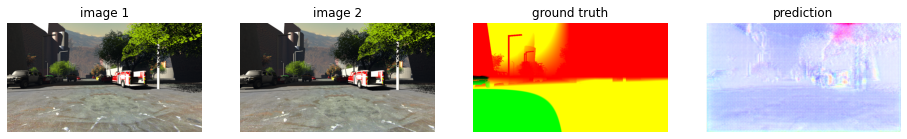

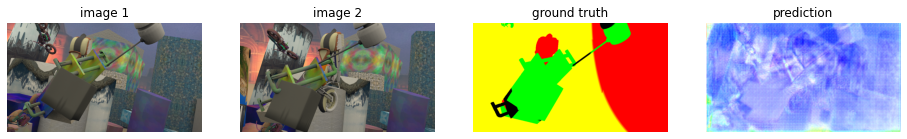

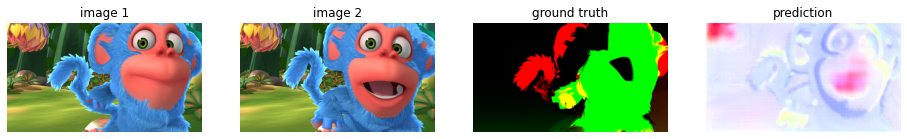

In [39]:
# DO NOT RERUN!
# The results for no pretraining and finetuning FlowNetS on 520 Sintel image pairs with NO data augmentation
visualize_results("driving")
visualize_results("flying")
visualize_results("monkey")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


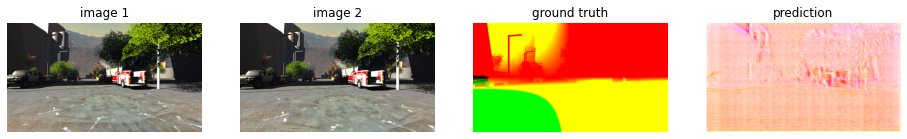

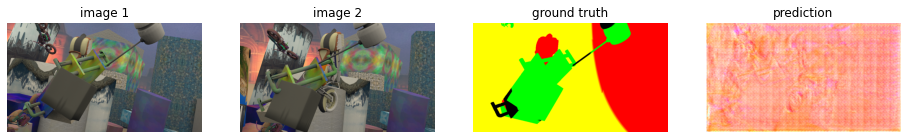

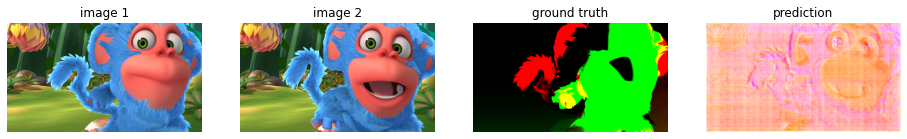

In [41]:
# DO NOT RERUN!
# The results for no pretraining and finetuning FlowNetS on 520 Sintel image pairs with YES data augmentation
visualize_results("driving")
visualize_results("flying")
visualize_results("monkey")